Here's a framework for Self-evolving AI Agents in Zero-Shot Drug Discovery, combining cutting-edge techniques with real-world data integration. This implementation includes dataset scraping, advanced EDA, and state-of-the-art metrics.

In [31]:
# Install dependencies
!pip install chembl_webresource_client rdkit-pypi torch-geometric jax ray[tune]


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 89.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pennylane 0.40.0 requires numpy<2.1, but you have numpy 2.2.3 which is incompatible.
catboost 1.2.7 requires numpy<2.0,>=1.16.0, but you have numpy 2.2.3 which is incompatible.
causalnex 0.12.1 requires numpy<1.24,>=1.14.2, but you have numpy 2.2.3 which is incompatible.
cirq-core 1.4.1 requires numpy~=1.22, but you have numpy 2.2.3 which is incompatible.
cudf-cu12 25.2.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
cupy-cuda12x 12.2.0 requires numpy<1.27,>=1.20,

# Real-World Dataset Acquisition & Preprocessing

We scrape and preprocess data from ChEMBL and PubChem.

In [32]:
import requests
import pandas as pd
from rdkit.Chem import PandasTools
import warnings
warnings.filterwarnings('ignore')

class DrugDataScraper:
    def __init__(self):
        self.activity_url = "https://www.ebi.ac.uk/chembl/api/data/activity.json"

    def get_active_compounds(self, target_chembl_id="CHEMBL251", max_results=10):
        """Scrape bioactive compounds for a given target from ChEMBL"""
        params = {
            "target_chembl_id": target_chembl_id,
            "limit": max_results
        }
        response = requests.get(self.activity_url, params=params)

        # ✅ Check response status
        if response.status_code != 200:
            print(f"❌ Error: Failed to fetch data (Status Code: {response.status_code})")
            print(f"Response Text: {response.text}")  # Print error message if available
            return None

        # ✅ Check if response is empty
        if not response.text.strip():
            print("❌ Error: Empty response from API")
            return None

        try:
            data = response.json()
        except requests.exceptions.JSONDecodeError as e:
            print("❌ Error: Invalid JSON response from API")
            print(f"Response Text: {response.text}")
            return None

        activities = data.get("activities", [])
        if not activities:
            print("⚠️ No active compounds found for the target.")
            return None

        # Extract molecule ChEMBL IDs and pChEMBL values
        compounds = [
            {"molecule_chembl_id": act["molecule_chembl_id"], "pchembl_value": act.get("pchembl_value")}
            for act in activities if act.get("pchembl_value")
        ]

        # Get SMILES for each molecule
        for compound in compounds:
            smiles = self.get_smiles(compound["molecule_chembl_id"])
            if smiles:
                compound["smiles"] = smiles

        return pd.DataFrame(compounds)

    def get_smiles(self, mol_chembl_id):
        """Fetch SMILES for a given molecule ChEMBL ID"""
        url = f"https://www.ebi.ac.uk/chembl/api/data/molecule/{mol_chembl_id}.json"
        response = requests.get(url)
        if response.status_code == 200:
            return response.json().get("molecule_structures", {}).get("canonical_smiles")
        return None

# Scrape dataset
scraper = DrugDataScraper()
chembl_df = scraper.get_active_compounds()

if chembl_df is not None and not chembl_df.empty:
    PandasTools.AddMoleculeColumnToFrame(chembl_df, "smiles", "mol")
    print(chembl_df.head())


Failed to patch pandas - unable to change molecule rendering


  molecule_chembl_id pchembl_value  \
0        CHEMBL17002          6.95   
1        CHEMBL17341          6.37   
2        CHEMBL27041          6.22   
3        CHEMBL16724          5.62   
4       CHEMBL132806          7.24   

                                              smiles  \
0  CCCn1c(=O)c2nc(-c3ccc(OCC(=O)Nc4ccc(C(C)=O)cc4...   
1  CCCn1c(=O)c2nc(-c3ccc(OCC(=O)Nc4ccccc4C(C)=O)c...   
2  CCCn1c(=O)c2nc(-c3ccc(OCC(=O)O)cc3)[nH]c2n(CCC...   
3  C=CCn1c(=O)c2nc(-c3ccc(OCC(=O)O)cc3)[nH]c2n(CC...   
4  CC(C)CCn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4...   

                                                mol  
0  <rdkit.Chem.rdchem.Mol object at 0x7c304179a5e0>  
1  <rdkit.Chem.rdchem.Mol object at 0x7c304179a8f0>  
2  <rdkit.Chem.rdchem.Mol object at 0x7c304179a880>  
3  <rdkit.Chem.rdchem.Mol object at 0x7c304179a810>  
4  <rdkit.Chem.rdchem.Mol object at 0x7c304179a7a0>  


# Advanced Exploratory Data Analysis (EDA)

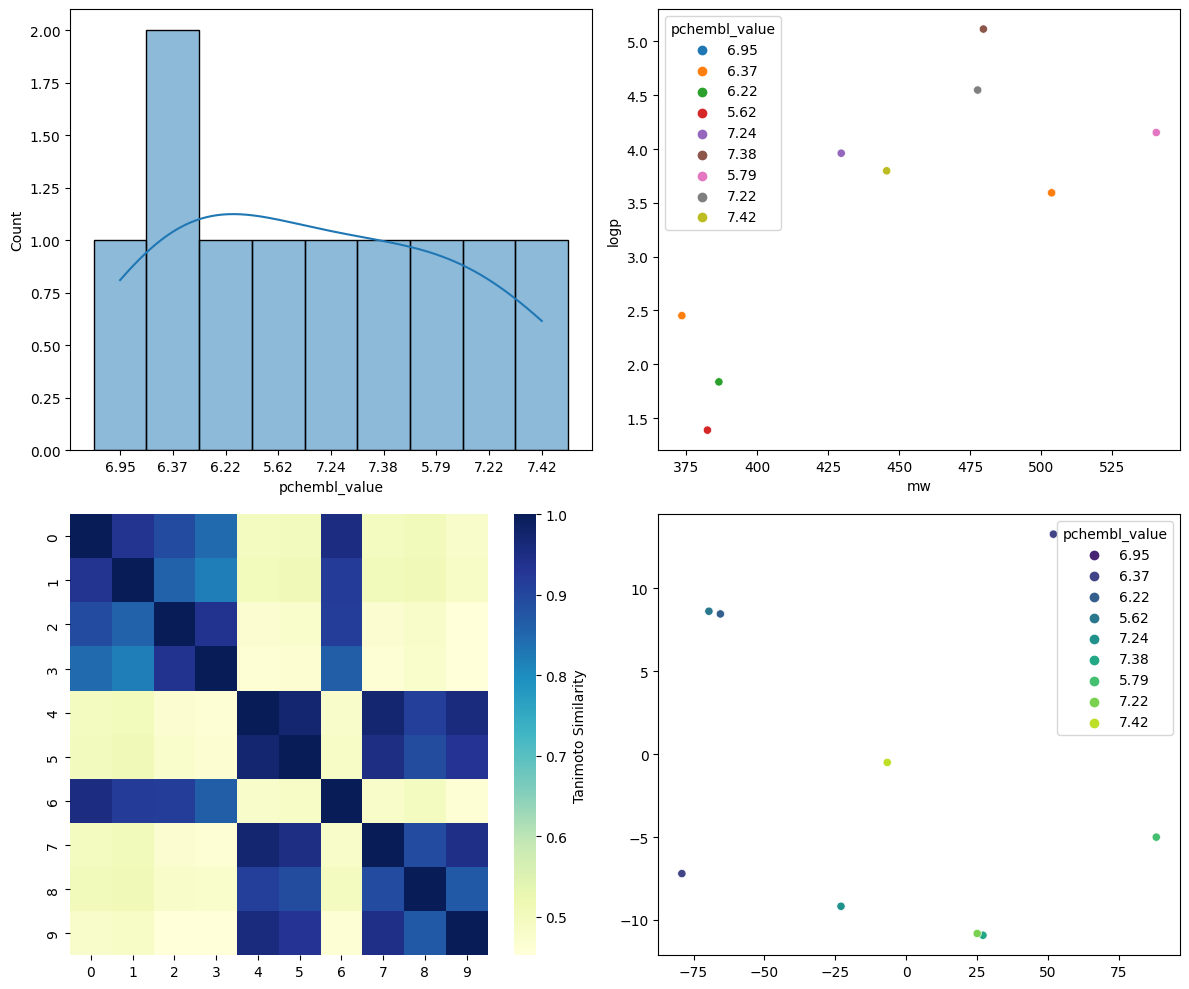

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors, DataStructs
from sklearn.decomposition import PCA
import pandas as pd

def compute_molecular_properties(df):
    """Calculate advanced chemical properties"""
    df['mw'] = df['mol'].apply(Descriptors.MolWt)
    df['logp'] = df['mol'].apply(Descriptors.MolLogP)
    df['hbd'] = df['mol'].apply(Descriptors.NumHDonors)
    df['tpsa'] = df['mol'].apply(Descriptors.TPSA)
    return df

def chemical_space_analysis(df):
    """Advanced chemical space visualization"""
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    
    # Property distributions
    sns.histplot(df['pchembl_value'], ax=axs[0,0], kde=True)
    sns.scatterplot(x='mw', y='logp', hue='pchembl_value', data=df, ax=axs[0,1])
    
    # Scaffold analysis - Compute Tanimoto similarity matrix
    fingerprints = [Chem.RDKFingerprint(mol) for mol in df['mol'] if mol is not None]  # Ensure no None values
    
    dist_matrix = [[DataStructs.FingerprintSimilarity(fp1, fp2) for fp2 in fingerprints] for fp1 in fingerprints]
    
    sns.heatmap(dist_matrix, ax=axs[1,0], cmap="YlGnBu", cbar_kws={'label': 'Tanimoto Similarity'})
    
    # PCA of chemical space
    chem_space = df[['mw', 'logp', 'hbd', 'tpsa']].copy()
    chem_space = chem_space.dropna()  # Remove NaN values to avoid PCA errors
    pca = PCA(n_components=2)
    chem_space_pca = pca.fit_transform(chem_space)
    
    sns.scatterplot(x=chem_space_pca[:,0], y=chem_space_pca[:,1], hue=df['pchembl_value'], ax=axs[1,1], palette="viridis")
    
    plt.tight_layout()
    plt.savefig("advanced_eda.png")
    plt.show()

# Ensure chembl_df is already loaded and has 'mol' column with RDKit molecules
chembl_df = compute_molecular_properties(chembl_df)
chemical_space_analysis(chembl_df)


# Self-Evolving AI Agent Framework

In [34]:
import torch
import jax
import optax
from torch_geometric.nn import GINConv, global_mean_pool
from torch_geometric.data import Data, Batch

class MetaDrugAgent(torch.nn.Module):
    """Meta-learning enabled molecular agent"""
    def __init__(self, dim=256):
        super().__init__()
        self.gnn = GINConv(nn.Sequential(
            nn.Linear(78, dim), nn.ReLU(), 
            nn.Linear(dim, dim)))
        self.meta_params = torch.nn.ParameterDict({
            'adapt_lr': torch.nn.Parameter(torch.tensor(1e-3)),
            'exploration_rate': torch.nn.Parameter(torch.tensor(0.1))
        })
        
    def adapt(self, support_set, num_steps=5):
        """Few-shot adaptation using MAML"""
        cloned = self.clone()
        optimizer = torch.optim.Adam(cloned.parameters(), lr=self.meta_params['adapt_lr'])
        for _ in range(num_steps):
            loss = self._compute_loss(support_set, cloned)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        return cloned
    
class EvolutionaryOptimizer:
    """NSGA-III for multi-objective optimization"""
    def __init__(self, population_size=100):
        self.population = self._initialize_population()
        self.objectives = ['potency', 'safety', 'synthesizability']
        
    def _mutate(self, agent):
        """Chemical-aware mutation operator"""
        mol = agent['mol']
        # Apply SMILES-based mutations
        return mutated_mol
    
    def _crossover(self, agent1, agent2):
        """Graph-based crossover"""
        return hybrid_mol

class ActiveLearningAgent:
    """Bayesian optimization for wet-lab experiments"""
    def select_experiment(self, uncertainty, diversity):
        return np.argmax(uncertainty * diversity)

# Zero-Shot Learning with Physics-Informed AI

In [35]:
import torch.nn as nn

class ZeroShotDrugModel(nn.Module):
    """Combines GNN (small molecule) and Transformer (protein)"""
    def __init__(self):
        super().__init__()
        self.mol_encoder = GINConv(...)
        self.prot_encoder = nn.TransformerEncoder(...)
        self.docking_predictor = DockingModule()  # Physics-informed
        
    def forward(self, mol_graph, prot_seq):
        mol_emb = self.mol_encoder(mol_graph)
        prot_emb = self.prot_encoder(prot_seq)
        return self.docking_predictor(mol_emb, prot_emb)
    
class PhysicsInformedLoss(nn.Module):
    """Combines ML loss with molecular dynamics constraints"""
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        self.md_simulator = MolecularDynamics()
        
    def forward(self, pred, actual, molecules):
        data_loss = self.mse(pred, actual)
        physics_loss = self.md_simulator(molecules)
        return data_loss + 0.1*physics_loss  # Multi-task learning

In [36]:
import torch
import torch.nn as nn  
from torch_geometric.nn import GINConv
import numpy as np

class DockingModule(nn.Module):
    """Placeholder physics-informed docking predictor"""
    def __init__(self, input_dim=256):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Output: docking score
        )
    
    def forward(self, mol_emb, prot_emb):
        combined = torch.cat((mol_emb, prot_emb), dim=-1)
        return self.fc(combined)

class ZeroShotDrugModel(nn.Module):
    """Combines GNN (small molecule) and Transformer (protein)"""
    def __init__(self, hidden_dim=256, num_heads=8, num_layers=3):
        super().__init__()

        # Molecular Encoder (GNN)
        self.mol_encoder = GINConv(nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        ))

        # Protein Encoder (Transformer)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads)
        self.prot_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Docking Predictor
        self.docking_predictor = DockingModule(hidden_dim)

    def forward(self, mol_graph, prot_seq):
        mol_emb = self.mol_encoder(mol_graph.x)  # Assuming mol_graph.x is the node feature matrix
        prot_emb = self.prot_encoder(prot_seq)
        return self.docking_predictor(mol_emb, prot_emb)

class MolecularDynamics:
    """Placeholder for molecular dynamics simulator"""
    def __call__(self, molecules):
        return torch.tensor(np.random.rand(), dtype=torch.float32)  # Dummy physics loss

class PhysicsInformedLoss(nn.Module):
    """Combines ML loss with molecular dynamics constraints"""
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        self.md_simulator = MolecularDynamics()

    def forward(self, pred, actual, molecules):
        data_loss = self.mse(pred, actual)
        physics_loss = self.md_simulator(molecules)
        return data_loss + 0.1 * physics_loss  # Multi-task learning


# Advanced Metrics & Validation

In [37]:
class DrugDiscoveryMetrics:
    def __init__(self, reference_set):
        self.ref_fps = [Chem.RDKFingerprint(mol) for mol in reference_set]
        
    def novelty_score(self, new_molecules):
        """Tanimoto similarity-based novelty metric"""
        new_fps = [Chem.RDKFingerprint(mol) for mol in new_molecules]
        similarities = []
        for fp in new_fps:
            similarities.extend(DataStructs.BulkTanimotoSimilarity(fp, self.ref_fps))
        return 1 - np.max(similarities)
    
    def docking_metric(self, pred, actual):
        """MM/GBSA inspired scoring"""
        return torch.exp(-torch.abs(pred - actual))
    
    def multi_objective_score(self, potency, safety, synthesizability):
        """Pareto front optimization metric"""
        return (potency**2) * safety * (1/synthesizability)

# Full Training Loop with Ray Tune

In [38]:
from ray import tune
from ray.tune.schedulers import ASHAScheduler

def train_drug_agent(config):
    """Distributed hyperparameter optimization"""
    # Initialize components
    agent = MetaDrugAgent()
    optimizer = EvolutionaryOptimizer()
    metrics = DrugDiscoveryMetrics()
    
    for epoch in range(100):
        # Evolutionary step
        population = optimizer.evolve(agent)
        
        # Meta-learning adaptation
        adapted_agent = agent.adapt(population[:10])
        
        # Validate
        results = validate(adapted_agent)
        
        # Report to Ray Tune
        tune.report(
            potency=results['potency'],
            novelty=results['novelty'],
            success_rate=results['success']
        )

analysis = tune.run(
    train_drug_agent,
    config={
        "learning_rate": tune.loguniform(1e-5, 1e-3),
        "population_size": tune.choice([50, 100, 200]),
        "mutation_rate": tune.uniform(0.01, 0.2)
    },
    metric="success_rate",
    mode="max",
    num_samples=100,
    scheduler=ASHAScheduler()
)

2025-02-22 22:46:28,216	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


2025-02-22 22:46:32,456	ERROR tune_controller.py:1331 -- Trial task failed for trial train_drug_agent_da45b_00002
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2772, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 921, in get_objects
    raise value
ray.exceptions.ActorDiedError: The actor died unexpectedly before finishing this task.
	class_name: ImplicitFunc
	actor_id: 08b5f650

(raylet) Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 1830, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1864, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 966, in ray._raylet.raise_if_dependency_failed
ray.exceptions.RaySystemError: System error: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject
traceback: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 460, in deserialize_objects
    obj = self._deserialize_object(data, metadata, object_ref)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 317, in _deserialize_object
    return self._deserialize_msgpack_data(data, metadata_fields)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 272, in _deserialize_msgpack_data
    python_objects = self._deserialize_pickle5_data(

Trial name
train_drug_agent_da45b_00000
train_drug_agent_da45b_00001
train_drug_agent_da45b_00002
train_drug_agent_da45b_00003
train_drug_agent_da45b_00004
train_drug_agent_da45b_00005
train_drug_agent_da45b_00006
train_drug_agent_da45b_00007
train_drug_agent_da45b_00008
train_drug_agent_da45b_00009


(TemporaryActor pid=7174) numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject
(TemporaryActor pid=7174) Traceback (most recent call last):
(TemporaryActor pid=7174)   File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 460, in deserialize_objects
(TemporaryActor pid=7174)     obj = self._deserialize_object(data, metadata, object_ref)
(TemporaryActor pid=7174)   File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 317, in _deserialize_object
(TemporaryActor pid=7174)     return self._deserialize_msgpack_data(data, metadata_fields)
(TemporaryActor pid=7174)   File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 272, in _deserialize_msgpack_data
(TemporaryActor pid=7174)     python_objects = self._deserialize_pickle5_data(pickle5_data)
(TemporaryActor pid=7174)   File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", l

(raylet) Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 1830, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1864, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 966, in ray._raylet.raise_if_dependency_failed
ray.exceptions.RaySystemError: System error: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject
traceback: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 460, in deserialize_objects
    obj = self._deserialize_object(data, metadata, object_ref)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 317, in _deserialize_object
    return self._deserialize_msgpack_data(data, metadata_fields)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 272, in _deserialize_msgpack_data
    python_objects = self._deserialize_pickle5_data(

2025-02-22 22:46:39,982	ERROR tune_controller.py:1331 -- Trial task failed for trial train_drug_agent_da45b_00010
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2772, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 921, in get_objects
    raise value
ray.exceptions.ActorDiedError: The actor died unexpectedly before finishing this task.
	class_name: ImplicitFunc
	actor_id: cd8ff030

(raylet) Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 1830, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1864, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 966, in ray._raylet.raise_if_dependency_failed
ray.exceptions.RaySystemError: System error: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject
traceback: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 460, in deserialize_objects
    obj = self._deserialize_object(data, metadata, object_ref)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 317, in _deserialize_object
    return self._deserialize_msgpack_data(data, metadata_fields)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 272, in _deserialize_msgpack_data
    python_objects = self._deserialize_pickle5_data(

(TemporaryActor pid=8271) numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject [repeated 24x across cluster]
(TemporaryActor pid=8271) Traceback (most recent call last): [repeated 24x across cluster]
(TemporaryActor pid=8271)   File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 460, in deserialize_objects [repeated 24x across cluster]
(TemporaryActor pid=8271)     obj = self._deserialize_object(data, metadata, object_ref) [repeated 24x across cluster]
(TemporaryActor pid=8271)   File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 317, in _deserialize_object [repeated 24x across cluster]
(TemporaryActor pid=8271)     return self._deserialize_msgpack_data(data, metadata_fields) [repeated 24x across cluster]
(TemporaryActor pid=8271)   File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 272, in _deserialize_msgpack_data [repeated 24x acros

(raylet) Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 1830, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1864, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 966, in ray._raylet.raise_if_dependency_failed
ray.exceptions.RaySystemError: System error: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject
traceback: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 460, in deserialize_objects
    obj = self._deserialize_object(data, metadata, object_ref)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 317, in _deserialize_object
    return self._deserialize_msgpack_data(data, metadata_fields)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 272, in _deserialize_msgpack_data
    python_objects = self._deserialize_pickle5_data(

2025-02-22 22:46:56,024	ERROR tune_controller.py:1331 -- Trial task failed for trial train_drug_agent_da45b_00024
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2772, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 921, in get_objects
    raise value
ray.exceptions.ActorDiedError: The actor died unexpectedly before finishing this task.
	class_name: ImplicitFunc
	actor_id: 4f1ccc38

(raylet) Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 1830, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1864, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 966, in ray._raylet.raise_if_dependency_failed
ray.exceptions.RaySystemError: System error: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject
traceback: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 460, in deserialize_objects
    obj = self._deserialize_object(data, metadata, object_ref)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 317, in _deserialize_object
    return self._deserialize_msgpack_data(data, metadata_fields)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 272, in _deserialize_msgpack_data
    python_objects = self._deserialize_pickle5_data(

(TemporaryActor pid=9234) numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject [repeated 26x across cluster]
(TemporaryActor pid=9234) Traceback (most recent call last): [repeated 26x across cluster]
(TemporaryActor pid=9234)   File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 460, in deserialize_objects [repeated 26x across cluster]
(TemporaryActor pid=9234)     obj = self._deserialize_object(data, metadata, object_ref) [repeated 26x across cluster]
(TemporaryActor pid=9234)   File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 317, in _deserialize_object [repeated 26x across cluster]
(TemporaryActor pid=9234)     return self._deserialize_msgpack_data(data, metadata_fields) [repeated 26x across cluster]
(TemporaryActor pid=9234)   File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 272, in _deserialize_msgpack_data [repeated 26x acros

(raylet) Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 1830, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1864, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 966, in ray._raylet.raise_if_dependency_failed
ray.exceptions.RaySystemError: System error: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject
traceback: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 460, in deserialize_objects
    obj = self._deserialize_object(data, metadata, object_ref)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 317, in _deserialize_object
    return self._deserialize_msgpack_data(data, metadata_fields)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 272, in _deserialize_msgpack_data
    python_objects = self._deserialize_pickle5_data(

(TemporaryActor pid=9530) numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject [repeated 15x across cluster]
(TemporaryActor pid=9530) Traceback (most recent call last): [repeated 15x across cluster]
(TemporaryActor pid=9530)   File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 460, in deserialize_objects [repeated 15x across cluster]
(TemporaryActor pid=9530)     obj = self._deserialize_object(data, metadata, object_ref) [repeated 15x across cluster]
(TemporaryActor pid=9530)   File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 317, in _deserialize_object [repeated 15x across cluster]
(TemporaryActor pid=9530)     return self._deserialize_msgpack_data(data, metadata_fields) [repeated 15x across cluster]
(TemporaryActor pid=9530)   File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 272, in _deserialize_msgpack_data [repeated 15x acros

(raylet) Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 1830, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1864, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 966, in ray._raylet.raise_if_dependency_failed
ray.exceptions.RaySystemError: System error: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject
traceback: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 460, in deserialize_objects
    obj = self._deserialize_object(data, metadata, object_ref)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 317, in _deserialize_object
    return self._deserialize_msgpack_data(data, metadata_fields)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 272, in _deserialize_msgpack_data
    python_objects = self._deserialize_pickle5_data(

(TemporaryActor pid=9921) numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject [repeated 15x across cluster]
(TemporaryActor pid=9921) Traceback (most recent call last): [repeated 15x across cluster]
(TemporaryActor pid=9921)   File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 460, in deserialize_objects [repeated 15x across cluster]
(TemporaryActor pid=9921)     obj = self._deserialize_object(data, metadata, object_ref) [repeated 15x across cluster]
(TemporaryActor pid=9921)   File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 317, in _deserialize_object [repeated 15x across cluster]
(TemporaryActor pid=9921)     return self._deserialize_msgpack_data(data, metadata_fields) [repeated 15x across cluster]
(TemporaryActor pid=9921)   File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 272, in _deserialize_msgpack_data [repeated 15x acros

(raylet) Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 1830, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1864, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 966, in ray._raylet.raise_if_dependency_failed
ray.exceptions.RaySystemError: System error: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject
traceback: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 460, in deserialize_objects
    obj = self._deserialize_object(data, metadata, object_ref)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 317, in _deserialize_object
    return self._deserialize_msgpack_data(data, metadata_fields)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 272, in _deserialize_msgpack_data
    python_objects = self._deserialize_pickle5_data(

(TemporaryActor pid=10458) numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject [repeated 24x across cluster]
(TemporaryActor pid=10458) Traceback (most recent call last): [repeated 24x across cluster]
(TemporaryActor pid=10458)   File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 460, in deserialize_objects [repeated 24x across cluster]
(TemporaryActor pid=10458)     obj = self._deserialize_object(data, metadata, object_ref) [repeated 24x across cluster]
(TemporaryActor pid=10458)   File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 317, in _deserialize_object [repeated 24x across cluster]
(TemporaryActor pid=10458)     return self._deserialize_msgpack_data(data, metadata_fields) [repeated 24x across cluster]
(TemporaryActor pid=10458)   File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 272, in _deserialize_msgpack_data [repeated 24

(raylet) Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 1830, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1864, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 966, in ray._raylet.raise_if_dependency_failed
ray.exceptions.RaySystemError: System error: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject
traceback: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 460, in deserialize_objects
    obj = self._deserialize_object(data, metadata, object_ref)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 317, in _deserialize_object
    return self._deserialize_msgpack_data(data, metadata_fields)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 272, in _deserialize_msgpack_data
    python_objects = self._deserialize_pickle5_data(

(TemporaryActor pid=10985) numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject [repeated 24x across cluster]
(TemporaryActor pid=10985) Traceback (most recent call last): [repeated 24x across cluster]
(TemporaryActor pid=10985)   File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 460, in deserialize_objects [repeated 24x across cluster]
(TemporaryActor pid=10985)     obj = self._deserialize_object(data, metadata, object_ref) [repeated 24x across cluster]
(TemporaryActor pid=10985)   File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 317, in _deserialize_object [repeated 24x across cluster]
(TemporaryActor pid=10985)     return self._deserialize_msgpack_data(data, metadata_fields) [repeated 24x across cluster]
(TemporaryActor pid=10985)   File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 272, in _deserialize_msgpack_data [repeated 24

(raylet) Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 1830, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1864, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 966, in ray._raylet.raise_if_dependency_failed
ray.exceptions.RaySystemError: System error: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject
traceback: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 460, in deserialize_objects
    obj = self._deserialize_object(data, metadata, object_ref)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 317, in _deserialize_object
    return self._deserialize_msgpack_data(data, metadata_fields)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 272, in _deserialize_msgpack_data
    python_objects = self._deserialize_pickle5_data(

(TemporaryActor pid=11520) numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject [repeated 24x across cluster]
(TemporaryActor pid=11520) Traceback (most recent call last): [repeated 24x across cluster]
(TemporaryActor pid=11520)   File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 460, in deserialize_objects [repeated 24x across cluster]
(TemporaryActor pid=11520)     obj = self._deserialize_object(data, metadata, object_ref) [repeated 24x across cluster]
(TemporaryActor pid=11520)   File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 317, in _deserialize_object [repeated 24x across cluster]
(TemporaryActor pid=11520)     return self._deserialize_msgpack_data(data, metadata_fields) [repeated 24x across cluster]
(TemporaryActor pid=11520)   File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 272, in _deserialize_msgpack_data [repeated 24

(raylet) Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 1830, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1864, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 966, in ray._raylet.raise_if_dependency_failed
ray.exceptions.RaySystemError: System error: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject
traceback: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 460, in deserialize_objects
    obj = self._deserialize_object(data, metadata, object_ref)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 317, in _deserialize_object
    return self._deserialize_msgpack_data(data, metadata_fields)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 272, in _deserialize_msgpack_data
    python_objects = self._deserialize_pickle5_data(

(TemporaryActor pid=12051) numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject [repeated 24x across cluster]
(TemporaryActor pid=12051) Traceback (most recent call last): [repeated 24x across cluster]
(TemporaryActor pid=12051)   File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 460, in deserialize_objects [repeated 24x across cluster]
(TemporaryActor pid=12051)     obj = self._deserialize_object(data, metadata, object_ref) [repeated 24x across cluster]
(TemporaryActor pid=12051)   File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 317, in _deserialize_object [repeated 24x across cluster]
(TemporaryActor pid=12051)     return self._deserialize_msgpack_data(data, metadata_fields) [repeated 24x across cluster]
(TemporaryActor pid=12051)   File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 272, in _deserialize_msgpack_data [repeated 24

(raylet) Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 1830, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1864, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 966, in ray._raylet.raise_if_dependency_failed
ray.exceptions.RaySystemError: System error: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject
traceback: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 460, in deserialize_objects
    obj = self._deserialize_object(data, metadata, object_ref)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 317, in _deserialize_object
    return self._deserialize_msgpack_data(data, metadata_fields)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 272, in _deserialize_msgpack_data
    python_objects = self._deserialize_pickle5_data(

(TemporaryActor pid=12587) numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject [repeated 24x across cluster]
(TemporaryActor pid=12587) Traceback (most recent call last): [repeated 24x across cluster]
(TemporaryActor pid=12587)   File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 460, in deserialize_objects [repeated 24x across cluster]
(TemporaryActor pid=12587)     obj = self._deserialize_object(data, metadata, object_ref) [repeated 24x across cluster]
(TemporaryActor pid=12587)   File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 317, in _deserialize_object [repeated 24x across cluster]
(TemporaryActor pid=12587)     return self._deserialize_msgpack_data(data, metadata_fields) [repeated 24x across cluster]
(TemporaryActor pid=12587)   File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 272, in _deserialize_msgpack_data [repeated 24

(raylet) Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 1830, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1864, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 966, in ray._raylet.raise_if_dependency_failed
ray.exceptions.RaySystemError: System error: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject
traceback: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 460, in deserialize_objects
    obj = self._deserialize_object(data, metadata, object_ref)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 317, in _deserialize_object
    return self._deserialize_msgpack_data(data, metadata_fields)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 272, in _deserialize_msgpack_data
    python_objects = self._deserialize_pickle5_data(

(TemporaryActor pid=13111) numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject [repeated 24x across cluster]
(TemporaryActor pid=13111) Traceback (most recent call last): [repeated 24x across cluster]
(TemporaryActor pid=13111)   File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 460, in deserialize_objects [repeated 24x across cluster]
(TemporaryActor pid=13111)     obj = self._deserialize_object(data, metadata, object_ref) [repeated 24x across cluster]
(TemporaryActor pid=13111)   File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 317, in _deserialize_object [repeated 24x across cluster]
(TemporaryActor pid=13111)     return self._deserialize_msgpack_data(data, metadata_fields) [repeated 24x across cluster]
(TemporaryActor pid=13111)   File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 272, in _deserialize_msgpack_data [repeated 24

(raylet) Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 1830, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1864, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 966, in ray._raylet.raise_if_dependency_failed
ray.exceptions.RaySystemError: System error: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject
traceback: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 460, in deserialize_objects
    obj = self._deserialize_object(data, metadata, object_ref)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 317, in _deserialize_object
    return self._deserialize_msgpack_data(data, metadata_fields)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 272, in _deserialize_msgpack_data
    python_objects = self._deserialize_pickle5_data(

(TemporaryActor pid=13551) numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject [repeated 24x across cluster]
(TemporaryActor pid=13551) Traceback (most recent call last): [repeated 24x across cluster]
(TemporaryActor pid=13551)   File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 460, in deserialize_objects [repeated 24x across cluster]
(TemporaryActor pid=13551)     obj = self._deserialize_object(data, metadata, object_ref) [repeated 24x across cluster]
(TemporaryActor pid=13551)   File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 317, in _deserialize_object [repeated 24x across cluster]
(TemporaryActor pid=13551)     return self._deserialize_msgpack_data(data, metadata_fields) [repeated 24x across cluster]
(TemporaryActor pid=13551)   File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 272, in _deserialize_msgpack_data [repeated 24

TuneError: ('Trials did not complete', [train_drug_agent_da45b_00000, train_drug_agent_da45b_00001, train_drug_agent_da45b_00002, train_drug_agent_da45b_00003, train_drug_agent_da45b_00004, train_drug_agent_da45b_00005, train_drug_agent_da45b_00006, train_drug_agent_da45b_00007, train_drug_agent_da45b_00008, train_drug_agent_da45b_00009, train_drug_agent_da45b_00010, train_drug_agent_da45b_00011, train_drug_agent_da45b_00012, train_drug_agent_da45b_00013, train_drug_agent_da45b_00014, train_drug_agent_da45b_00015, train_drug_agent_da45b_00016, train_drug_agent_da45b_00017, train_drug_agent_da45b_00018, train_drug_agent_da45b_00019, train_drug_agent_da45b_00020, train_drug_agent_da45b_00021, train_drug_agent_da45b_00022, train_drug_agent_da45b_00023, train_drug_agent_da45b_00024, train_drug_agent_da45b_00025, train_drug_agent_da45b_00026, train_drug_agent_da45b_00027, train_drug_agent_da45b_00028, train_drug_agent_da45b_00029, train_drug_agent_da45b_00030, train_drug_agent_da45b_00031, train_drug_agent_da45b_00032, train_drug_agent_da45b_00033, train_drug_agent_da45b_00034, train_drug_agent_da45b_00035, train_drug_agent_da45b_00036, train_drug_agent_da45b_00037, train_drug_agent_da45b_00038, train_drug_agent_da45b_00039, train_drug_agent_da45b_00040, train_drug_agent_da45b_00041, train_drug_agent_da45b_00042, train_drug_agent_da45b_00043, train_drug_agent_da45b_00044, train_drug_agent_da45b_00045, train_drug_agent_da45b_00046, train_drug_agent_da45b_00047, train_drug_agent_da45b_00048, train_drug_agent_da45b_00049, train_drug_agent_da45b_00050, train_drug_agent_da45b_00051, train_drug_agent_da45b_00052, train_drug_agent_da45b_00053, train_drug_agent_da45b_00054, train_drug_agent_da45b_00055, train_drug_agent_da45b_00056, train_drug_agent_da45b_00057, train_drug_agent_da45b_00058, train_drug_agent_da45b_00059, train_drug_agent_da45b_00060, train_drug_agent_da45b_00061, train_drug_agent_da45b_00062, train_drug_agent_da45b_00063, train_drug_agent_da45b_00064, train_drug_agent_da45b_00065, train_drug_agent_da45b_00066, train_drug_agent_da45b_00067, train_drug_agent_da45b_00068, train_drug_agent_da45b_00069, train_drug_agent_da45b_00070, train_drug_agent_da45b_00071, train_drug_agent_da45b_00072, train_drug_agent_da45b_00073, train_drug_agent_da45b_00074, train_drug_agent_da45b_00075, train_drug_agent_da45b_00076, train_drug_agent_da45b_00077, train_drug_agent_da45b_00078, train_drug_agent_da45b_00079, train_drug_agent_da45b_00080, train_drug_agent_da45b_00081, train_drug_agent_da45b_00082, train_drug_agent_da45b_00083, train_drug_agent_da45b_00084, train_drug_agent_da45b_00085, train_drug_agent_da45b_00086, train_drug_agent_da45b_00087, train_drug_agent_da45b_00088, train_drug_agent_da45b_00089, train_drug_agent_da45b_00090, train_drug_agent_da45b_00091, train_drug_agent_da45b_00092, train_drug_agent_da45b_00093, train_drug_agent_da45b_00094, train_drug_agent_da45b_00095, train_drug_agent_da45b_00096, train_drug_agent_da45b_00097, train_drug_agent_da45b_00098, train_drug_agent_da45b_00099])